# Poisson HMM Example Notebook

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lindermanlab/ssm-jax-refactor/blob/main/notebooks/poisson-hmm-example.ipynb)

In [1]:
try:
    import ssm
except:
    !pip install git+https://github.com/lindermanlab/ssm-jax-refactor.git -qqq
    import ssm

#### Imports and Plotting Functions 

In [2]:
import jax.random as jr
import jax.numpy as np
import matplotlib.pyplot as plt

from ssm.utils import find_permutation
from ssm.plots import gradient_cmap
from ssm.hmm import PoissonHMM

import warnings

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

def plot_transition_matrix(transition_matrix):
    plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
    plt.xlabel("next state")
    plt.ylabel("current state")
    plt.colorbar()
    plt.show()
    
def compare_transition_matrix(true_matrix, test_matrix):
    fig, axs = plt.subplots(1, 2)
    out = axs[0].imshow(true_matrix, vmin=0, vmax=1, cmap="Greys")
    axs[1].imshow(test_matrix, vmin=0, vmax=1, cmap="Greys")
    axs[0].set_title("True Transition Matrix")
    axs[1].set_title("Test Transition Matrix")
    cax = fig.add_axes([axs[1].get_position().x1 + 0.07,
                        axs[1].get_position().y0,
                        0.02,
                        axs[1].get_position().y1-axs[1].get_position().y0])
    plt.colorbar(out, cax=cax)
    plt.show()

def plot_hmm_data(obs, states):
    lim = 1.01 * abs(obs).max()
    time_bins, obs_dim = obs.shape
    plt.figure(figsize=(8, 3))
    plt.imshow(states[None,:],
            aspect="auto",
            cmap=cmap,
            vmin=0,
            vmax=len(colors)-1,
            extent=(0, time_bins, -lim, (obs_dim)*lim))

    for d in range(obs_dim):
        plt.plot(obs[:,d] + lim * d, '-k')

    plt.xlim(0, time_bins)
    plt.xlabel("time")
    plt.yticks(lim * np.arange(obs_dim), ["$x_{}$".format(d+1) for d in range(obs_dim)])

    plt.title("Simulated data from an HMM")

    plt.tight_layout()
    
def plot_posterior_states(Ez, states, perm):
    plt.figure(figsize=(20, 2))
    plt.imshow(Ez.T[perm], aspect="auto", interpolation="none", cmap="Greys")
    plt.plot(states, label="True State")
    plt.plot(Ez.T[perm].argmax(axis=0), '--', label="Predicted State")
    plt.xlabel("time")
    plt.ylabel("latent state")
    plt.legend(bbox_to_anchor=(1,1))
    plt.title("Predicted vs. Ground Truth Latent State")
    plt.show()

# 2. Poisson HMM

### As before, let's create a true model

In [3]:
num_states = 5
num_channels = 10

transition_matrix = 0.90 * np.eye(num_states) + 0.10 * np.ones((num_states, num_states)) / num_states

true_hmm = PoissonHMM(num_states, 
                      num_emission_dims=num_channels,
                      transition_matrix=transition_matrix,
                      seed=jr.PRNGKey(0))

### Acessing model parameters
The HMM was initialized with a transition matrix, but what about the emission rates? Unless they are explicitly given to the constructor, they are initialized randomly using the specified seed.  We can access them via model properties.

In [4]:
print("Emission probabilities (num states x num emission_dims (aka channels)):")
print(true_hmm.emission_rates)

Emission probabilities (num states x num emission_dims (aka channels)):
[[2.32731    4.7042933  4.7147727  3.6188827  1.8785722  2.9218767
  3.2418182  1.0737233  0.95202875 3.681632  ]
 [3.373829   4.506029   1.0604829  1.7568102  4.019825   2.425489
  4.0328975  4.3800173  2.8734431  1.8425262 ]
 [1.903414   1.7478418  1.6828955  2.7750566  2.4077315  0.31438476
  4.410909   3.0964594  1.5256848  2.0441117 ]
 [3.3966694  3.3942928  6.420209   1.9779935  1.7987707  1.5110973
  1.0246713  6.001983   3.000935   4.5368776 ]
 [1.1979312  1.7388443  3.9184265  1.9244609  3.131378   7.542575
  1.8097417  3.6445234  2.389298   2.2099392 ]]


### From the true model, we can sample synthetic data

In [5]:
rng = jr.PRNGKey(0)
num_timesteps = 500

# There's an annoying warning/bug when sampling from Poisson TFP distributions currently
# We can suppress the warning here for convenience
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", "Explicitly requested dtype")
    states, data = true_hmm.sample(rng, num_timesteps)

### Let's view the synthetic data

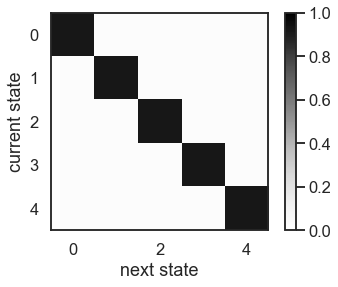

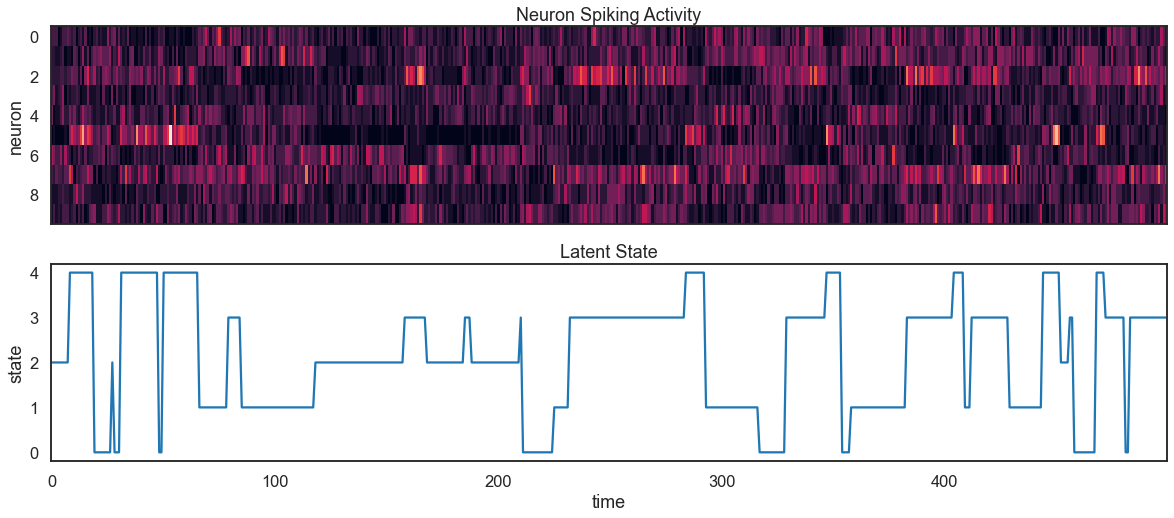

In [6]:
plot_transition_matrix(true_hmm.transition_matrix)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 8))
axs[0].imshow(data.T, aspect="auto", interpolation="none")
axs[0].set_ylabel("neuron")
axs[0].set_title("Neuron Spiking Activity")
axs[1].plot(states)
axs[1].set_title("Latent State")
axs[1].set_xlabel("time")
axs[1].set_ylabel("state")
plt.show()

## Fit HMM using exact EM update

In [7]:
test_hmm = PoissonHMM(num_states, num_channels, seed=jr.PRNGKey(32))
lps, test_hmm, posterior = test_hmm.fit(data, method="em", tol=-1)

Initializing...
Done.


LP: -9338.702: 100%|██████████| 100/100 [00:01<00:00, 70.22it/s]


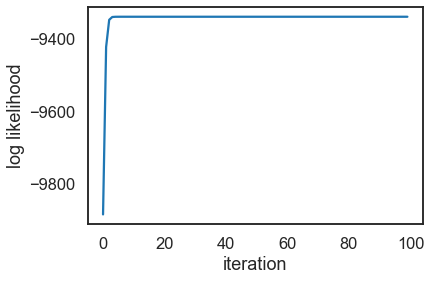

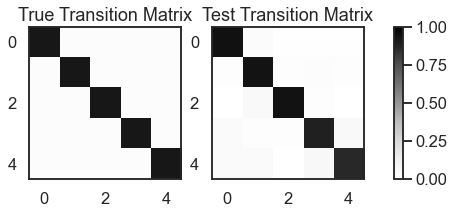

In [8]:
# Plot the log probabilities
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log likelihood")

# Compare the transition matrices
compare_transition_matrix(true_hmm.transition_matrix, test_hmm.transition_matrix)

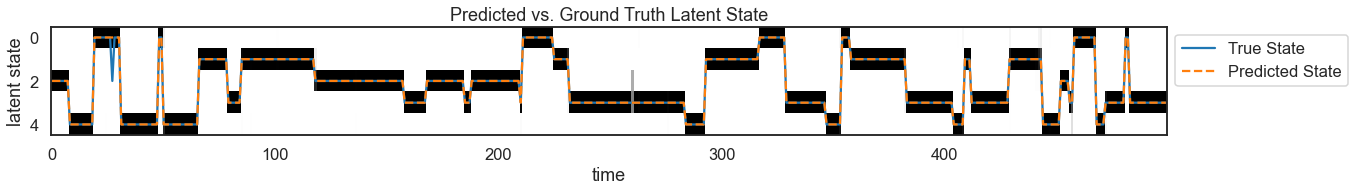

In [9]:
# Posterior distribution
Ez = posterior.expected_states.reshape(-1, num_states)
perm = find_permutation(states, np.argmax(Ez, axis=-1))
plot_posterior_states(Ez, states, perm)

## Fit Poisson HMM over multiple trials

In [10]:
rng = jr.PRNGKey(0)
num_timesteps = 500
num_trials = 5

# once again, we suppress the warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", "Explicitly requested dtype")
    all_states, all_data = true_hmm.sample(rng, num_timesteps, num_samples=num_trials)

In [11]:
# Now we have a batch dimension of size `num_trials`
print(all_states.shape)
print(all_data.shape)

(5, 500)
(5, 500, 10)


In [12]:
lps, test_hmm, posterior = test_hmm.fit(all_data, method="em", tol=-1)

Initializing...
Done.


LP: -46279.027: 100%|██████████| 100/100 [00:01<00:00, 54.24it/s]


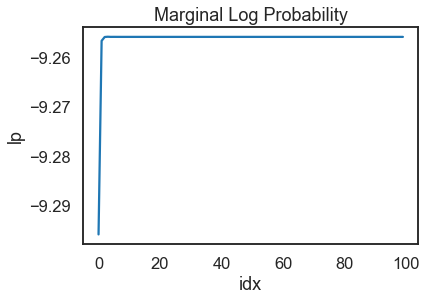

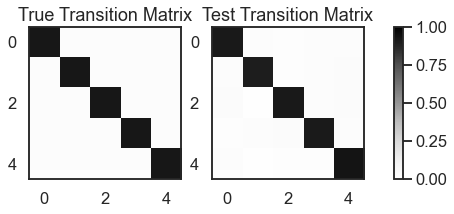

In [13]:
# plot marginal log probabilities
plt.title("Marginal Log Probability")
plt.ylabel("lp")
plt.xlabel("idx")
plt.plot(lps / data.size)

compare_transition_matrix(true_hmm.transition_matrix, test_hmm.transition_matrix)

===== Trial: 0 =====


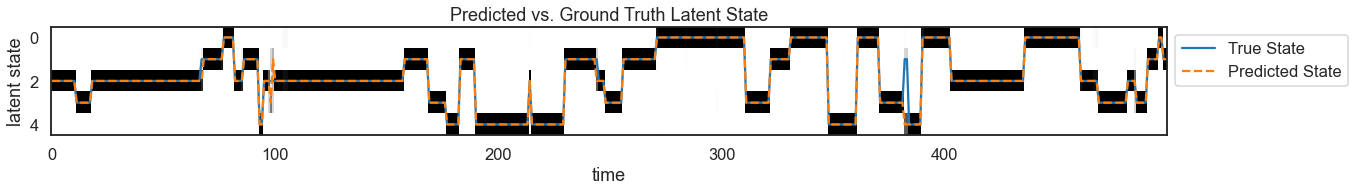

===== Trial: 1 =====


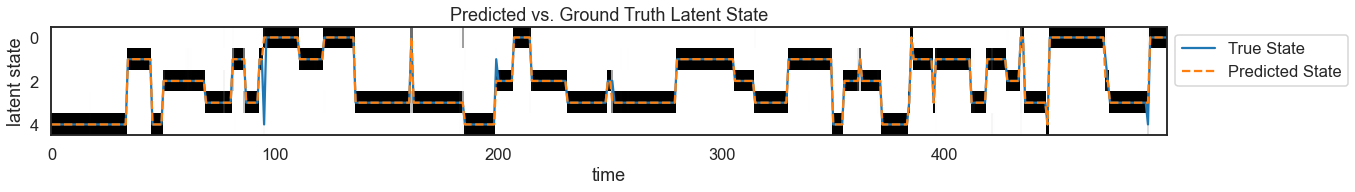

===== Trial: 2 =====


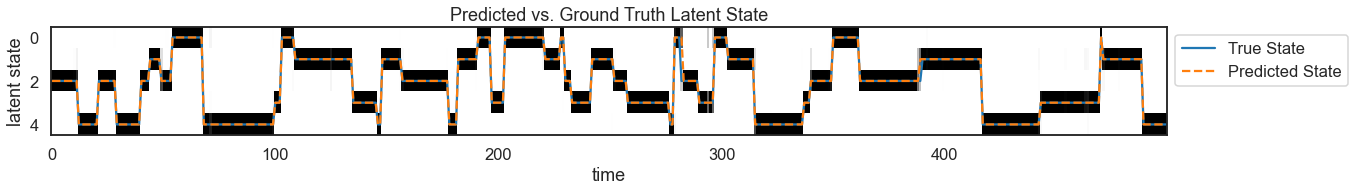

In [14]:
for trial_idx in range(3):
    print("="*5, f"Trial: {trial_idx}", "="*5)
    Ez = posterior.expected_states[trial_idx]
    states = all_states[trial_idx]
    perm = find_permutation(states, np.argmax(Ez, axis=-1))
    plot_posterior_states(Ez, states, perm)